In [1]:
from scipy.io import loadmat
import torch
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from extractor import ViTExtractor
from inspect_similarity import chunk_cosine_sim
from correspondences import draw_correspondences

In [2]:
def python2_round(n):
    # ACSM is Python2; for parity, we use Python2 rounding in these utils.
    # https://stackoverflow.com/a/33019948
    from decimal import localcontext, Decimal, ROUND_HALF_UP
    with localcontext() as ctx:
        ctx.rounding = ROUND_HALF_UP
        rounded = Decimal(n).to_integral_value()
    return rounded

def perturb_bbox(bbox, pf=0, jf=0):
    '''
    Jitters and pads the input bbox.
    Args:
        bbox: Zero-indexed tight bbox.
        pf: padding fraction.
        jf: jittering fraction.
    Returns:
        pet_bbox: Jittered and padded box. Might have -ve or out-of-image coordinates
    '''
    pet_bbox = [coord for coord in bbox]
    bwidth = bbox[2] - bbox[0] + 1
    bheight = bbox[3] - bbox[1] + 1

    pet_bbox[0] -= (pf*bwidth) + (1-2*np.random.random())*jf*bwidth
    pet_bbox[1] -= (pf*bheight) + (1-2*np.random.random())*jf*bheight
    pet_bbox[2] += (pf*bwidth) + (1-2*np.random.random())*jf*bwidth
    pet_bbox[3] += (pf*bheight) + (1-2*np.random.random())*jf*bheight

    return pet_bbox

def square_bbox(bbox, py2_round=True):
    '''
    Converts a bbox to have a square shape by increasing size along non-max dimension.
    '''
    round_fn = python2_round if py2_round else round
    sq_bbox = [int(round_fn(coord)) for coord in bbox]
    bwidth = sq_bbox[2] - sq_bbox[0] + 1
    bheight = sq_bbox[3] - sq_bbox[1] + 1
    maxdim = float(max(bwidth, bheight))

    dw_b_2 = int(round_fn((maxdim - bwidth) / 2.0))
    dh_b_2 = int(round_fn((maxdim - bheight) / 2.0))

    sq_bbox[0] -= dw_b_2
    sq_bbox[1] -= dh_b_2
    sq_bbox[2] = sq_bbox[0] + maxdim - 1
    sq_bbox[3] = sq_bbox[1] + maxdim - 1

    return sq_bbox

def load_CUB_keypoints(path):
    names = ['img_index', 'kp_index', 'x', 'y', 'visible']
    landmarks = pd.read_table(path, header=None, names=names, delim_whitespace=True, engine='python')
    landmarks = landmarks.to_numpy().reshape((11788, 15, 5))[..., [2, 3, 4]]  # (num_images, num_kps, 3)
    landmarks = torch.from_numpy(landmarks).float()
    return landmarks

def acsm_crop(img, bbox, bgval=0, border=True, py2_round=True):
    '''
    Crops a region from the image corresponding to the bbox.
    If some regions specified go outside the image boundaries, the pixel values are set to bgval.
    Args:
        img: image to crop
        bbox: bounding box to crop
        bgval: default background for regions outside image
    '''
    round_fn = python2_round if py2_round else round
    bbox = [int(round_fn(c)) for c in bbox]
    bwidth = bbox[2] - bbox[0] + 1
    bheight = bbox[3] - bbox[1] + 1

    im_shape = np.shape(img)
    im_h, im_w = im_shape[0], im_shape[1]

    nc = 1 if len(im_shape) < 3 else im_shape[2]

    img_out = np.ones((bheight, bwidth, nc), dtype=np.uint8) * bgval
    x_min_src = max(0, bbox[0])
    x_max_src = min(im_w, bbox[2] + 1)
    y_min_src = max(0, bbox[1])
    y_max_src = min(im_h, bbox[3] + 1)

    x_min_trg = x_min_src - bbox[0]
    x_max_trg = x_max_src - x_min_src + x_min_trg
    y_min_trg = y_min_src - bbox[1]
    y_max_trg = y_max_src - y_min_src + y_min_trg
    if border:
        img_in = img_out = img[y_min_src:y_max_src, x_min_src:x_max_src, :]
        left_pad = x_min_trg
        right_pad = bwidth - x_max_trg
        up_pad = y_min_trg
        down_pad = bheight - y_max_trg
        try:
            img_out = np.pad(img_out, mode='edge', pad_width=[(up_pad, down_pad), (left_pad, right_pad), (0, 0)])
            assert ((img_out[y_min_trg:y_max_trg, x_min_trg:x_max_trg, :] - img_in) ** 2).sum() == 0
            assert img_out.shape[0] == img_out.shape[1]
        except ValueError:
            print(f'crop_shape: {img_out.shape}, pad: {(up_pad, down_pad, left_pad, right_pad)}, trg: {(y_min_trg, y_max_trg, x_min_trg, x_max_trg)}, box: {(bheight, bwidth)}, img_shape: {im_shape}')
            exit()
        # assert img_out.shape == (256, 256, 3), f'got {img_out.shape}, {x_min_trg}, {x_max_trg}, {y_min_trg}, {y_max_trg}'
    else:
        img_out[y_min_trg:y_max_trg, x_min_trg:x_max_trg, :] = img[y_min_src:y_max_src, x_min_src:x_max_src, :]
    return img_out

def preprocess_kps_box_crop(kps, bbox, size):
    # Once an image has been pre-processed via a box crop,
    # the location of key points needs to be updated. This function applies
    # that pre-processing to the key points so they are correctly located
    # in the cropped image.
    kps = kps.clone()
    kps[:, 0] -= bbox[0] + 1
    kps[:, 1] -= bbox[1] + 1
    w = 1 + bbox[2] - bbox[0]
    h = 1 + bbox[3] - bbox[1]
    assert w == h
    kps[:, [0, 1]] *= size / float(w)
    return kps

def cub_crop(img, target_res, bbox):
    # This function mimics ACSM's pre-processing used for the CUB dataset (up to image resampling and padding color)
    img = np.asarray(img)
    img = acsm_crop(img, bbox, 0, border=True)
    return Image.fromarray(np.squeeze(img)).resize(
        (target_res, target_res), Image.Resampling.LANCZOS)

def load_acsm_data(path, size=256, split='val', cls_idx=None):
    mat = loadmat(os.path.join(path, f'CUB_200_2011/cachedir/cub/data/{split}_cub_cleaned.mat'))
    files = [os.path.join(path, f'CUB_200_2011/images/{file[0]}')
             for file in mat['images']['rel_path'][0]]
    labels = [int(file[0].split('.')[0]) for file in mat['images']['rel_path'][0]]

    # These are the indices retained by ACSM (others are filtered):
    indices = [i[0, 0] - 1 for i in mat['images']['id'][0]]
    kps = load_CUB_keypoints(os.path.join(path, 'CUB_200_2011/parts/part_locs.txt'))[indices]
    b = mat['images']['bbox'][0]
    m = mat['images']['mask'][0]
    if cls_idx is not None:
        cls_ind = [i for i, c in enumerate(labels) if c==cls_idx]
        files = [files[i] for i in cls_ind]
        b = b[cls_ind]
        kps = kps[cls_ind]
        m = m[cls_ind]
        
    bboxes = []
    kps_out = []
    masks = []
    for ix, row in enumerate(b):
        x1, y1, x2, y2 = row[0, 0]
        bbox = np.array([x1[0, 0], y1[0, 0], x2[0, 0], y2[0, 0]]) - 1
        bbox = perturb_bbox(bbox, 0.05, 0)
        bbox = square_bbox(bbox)
        bboxes.append(bbox)
        kps_out.append(preprocess_kps_box_crop(kps[ix], bbox, size))
        masks.append(torch.from_numpy(np.array(cub_crop(np.expand_dims(m[ix], -1), size, bbox))))
    bboxes = np.stack(bboxes)
    kps_out = torch.stack(kps_out)
    masks = torch.stack(masks).float()
    assert bboxes.shape[0] == len(files)

    return files, bboxes, kps_out, masks

In [3]:
files, bboxes, kps_out, masks = load_acsm_data('/mnt/data/CUB', cls_idx=1)

In [4]:
src_idx = 0
trg_idx = 1
img_size = 256

src_img = Image.open(files[src_idx]).convert('RGB')
src_bbox = bboxes[src_idx]
src_img = cub_crop(src_img, img_size, src_bbox)
src_kps = kps_out[src_idx]

trg_img = Image.open(files[trg_idx]).convert('RGB')
trg_bbox = bboxes[trg_idx]
trg_img = cub_crop(trg_img, img_size, trg_bbox)
trg_kps = kps_out[trg_idx]

vis = src_kps[:, 2] * trg_kps[:, 2] > 0

In [6]:
load_size = 256
layer = 9
facet = 'key'
bin = False
stride = 4
model_type = 'dino_vits8'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
extractor = ViTExtractor(model_type, stride, device=device)
patch_size = extractor.model.patch_embed.patch_size
num_patches = int(patch_size / stride * (img_size // patch_size - 1) + 1)
masks = F.interpolate(masks.unsqueeze(1), (num_patches, num_patches), mode='bilinear', align_corners=True)
masks = masks.squeeze().to(device)

with torch.no_grad():
    src_img_batch = extractor.preprocess_pil(src_img)
    trg_img_batch = extractor.preprocess_pil(trg_img)

    src_desc = extractor.extract_descriptors(src_img_batch.to(device), layer, facet, bin)
    trg_desc = extractor.extract_descriptors(trg_img_batch.to(device), layer, facet, bin)
    similarities = chunk_cosine_sim(src_desc, trg_desc)[0, 0]

Using cache found in /home/kampta/.cache/torch/hub/facebookresearch_dino_main


(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

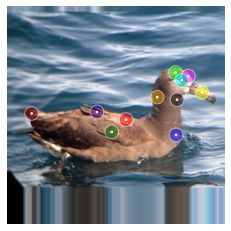

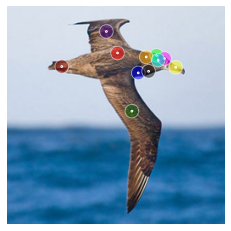

In [7]:
draw_correspondences(src_kps[vis][:, [1,0]], trg_kps[vis][:, [1,0]], src_img, trg_img)

In [8]:
src_y, src_x = (src_kps[vis][:, 1]+0.5).numpy(), (src_kps[vis][:, 0]+0.5).numpy()
src_y_patch = (num_patches / load_size * src_y).astype(np.int32)
src_x_patch = (num_patches / load_size * src_x).astype(np.int32)

In [9]:
src_patch_idx = num_patches * src_y_patch + src_x_patch
trg_mask = masks[trg_idx].reshape(-1).unsqueeze(0)
nn = torch.argmax(similarities[src_patch_idx]*trg_mask, dim=1)

In [10]:
nn_y_patch, nn_x_patch = nn // num_patches, nn % num_patches

/tmp/ipykernel_23580/298713991.py:1: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  nn_y_patch, nn_x_patch = nn // num_patches, nn % num_patches


In [11]:
nn_x = (nn_x_patch - 1) * stride + stride + patch_size // 2 - .5
nn_y = (nn_y_patch - 1) * stride + stride + patch_size // 2 - .5
src_kps_transfer = torch.stack([nn_x, nn_y]).permute(1, 0)

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

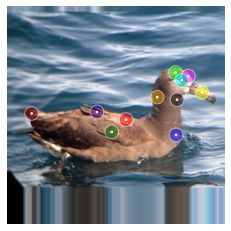

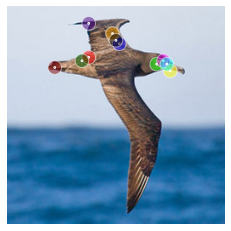

In [12]:
draw_correspondences(src_kps[vis][:, [1,0]], src_kps_transfer[:, [1,0]], src_img, trg_img)

## Multiple Images

In [13]:
gt_correspondences = []
pred_correspondences = []
img_size = 256
num_patches = int(patch_size / stride * (img_size // patch_size - 1) + 1)
N = len(files)
pbar = tqdm(total=N*(N-1)/2)

for idx1 in range(N-1):
    img1 = Image.open(files[idx1]).convert('RGB')
    img1_bbox = bboxes[idx1]
    img1 = cub_crop(img1, img_size, img1_bbox)
    img1_kps = kps_out[idx1]

    # Get patch index for the keypoints
    img1_y, img1_x = img1_kps[:, 1].numpy(), img1_kps[:, 0].numpy()
    img1_y_patch = (num_patches / img_size * img1_y).astype(np.int32)
    img1_x_patch = (num_patches / img_size * img1_x).astype(np.int32)
    img1_patch_idx = num_patches * img1_y_patch + img1_x_patch
    img1_mask = masks[idx1].reshape(-1).unsqueeze(0)

    with torch.no_grad():
        img1_batch = extractor.preprocess_pil(img1)
        img1_desc = extractor.extract_descriptors(img1_batch.to(device), layer, facet, bin)

    for idx2 in range(idx1+1, N):
        img2 = Image.open(files[idx2]).convert('RGB')
        img2_bbox = bboxes[idx2]
        img2 = cub_crop(img2, img_size, img2_bbox)
        img2_kps = kps_out[idx2]

        # Get mutual visibility
        vis = img1_kps[:, 2] * img2_kps[:, 2] > 0

        # Get patch index for the keypoints
        img2_y, img2_x = img2_kps[:, 1].numpy(), img2_kps[:, 0].numpy()
        img2_y_patch = (num_patches / img_size * img2_y).astype(np.int32)
        img2_x_patch = (num_patches / img_size * img2_x).astype(np.int32)
        img2_patch_idx = num_patches * img2_y_patch + img2_x_patch
        
        with torch.no_grad():
            img2_batch = extractor.preprocess_pil(img2)
            img2_desc = extractor.extract_descriptors(img2_batch.to(device), layer, facet, bin)

        # Get similarity matrix
        sim_1_to_2 = chunk_cosine_sim(img1_desc, img2_desc).squeeze()
        
        # Get 1 to 2 correspondences
        img2_mask = masks[idx2].reshape(-1).unsqueeze(0)

        nn_1_to_2 = torch.argmax(sim_1_to_2[img1_patch_idx] * img2_mask, dim=1)
        nn_y_patch, nn_x_patch = nn_1_to_2 // num_patches, nn_1_to_2 % num_patches
        nn_x = (nn_x_patch - 1) * stride + stride + patch_size // 2 - .5
        nn_y = (nn_y_patch - 1) * stride + stride + patch_size // 2 - .5
        kps_1_to_2 = torch.stack([nn_x, nn_y]).permute(1, 0)

        gt_correspondences.append(img1_kps[vis][:, [1,0]])
        pred_correspondences.append(kps_1_to_2[vis][:, [1,0]])

        # Get 2 to 1 correspondences
        nn_2_to_1 = torch.argmax(sim_1_to_2.T[img2_patch_idx] * img1_mask, dim=1)
        nn_y_patch, nn_x_patch = nn_2_to_1 // num_patches, nn_2_to_1 % num_patches
        nn_x = (nn_x_patch - 1) * stride + stride + patch_size // 2 - .5
        nn_y = (nn_y_patch - 1) * stride + stride + patch_size // 2 - .5
        kps_2_to_1 = torch.stack([nn_x, nn_y]).permute(1, 0)

        gt_correspondences.append(img2_kps[vis][:, [1,0]])
        pred_correspondences.append(kps_2_to_1[vis][:, [1,0]])
        pbar.update(1)

gt_correspondences = torch.cat(gt_correspondences, dim=0).cpu()
pred_correspondences = torch.cat(pred_correspondences, dim=0).cpu()

  0%|                                                      | 0/66.0 [00:00<?, ?it/s]/tmp/ipykernel_21373/3624522844.py:51: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  nn_y_patch, nn_x_patch = nn_1_to_2 // num_patches, nn_1_to_2 % num_patches
/tmp/ipykernel_21373/3624522844.py:61: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  nn_y_pa

In [14]:
alpha = torch.tensor([0.1, 0.05, 0.01])
correct = torch.zeros(len(alpha))

err = (pred_correspondences - gt_correspondences).norm(dim=-1)
err = err.unsqueeze(0).repeat(len(alpha), 1)
threshold = alpha * img_size
correct = err < threshold.unsqueeze(-1)
correct = correct.sum(dim=-1) / len(gt_correspondences)

alpha2pck = zip(alpha.tolist(), correct.tolist())
print(' | '.join([f'PCK-Transfer@{alpha:.2f}: {pck_alpha * 100:.2f}%'
                  for alpha, pck_alpha in alpha2pck]))

PCK-Transfer@0.10: 10.74% | PCK-Transfer@0.05: 2.87% | PCK-Transfer@0.01: 0.16%


## All categories

In [3]:
files, bboxes, kps_out = load_acsm_data('/mnt/data/CUB')

In [4]:
load_size = 256
layer = 9
facet = 'key'
bin = True
stride = 4
model_type = 'dino_vits8'
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [5]:
with torch.no_grad():
    extractor = ViTExtractor(model_type, stride, device=device)
    patch_size = extractor.model.patch_embed.patch_size


Using cache found in /home/kampta/.cache/torch/hub/facebookresearch_dino_main


In [6]:
gt_correspondences = []
pred_correspondences = []
img_size = 256
num_patches = int(patch_size / stride * (img_size // patch_size - 1) + 1)
N = 50
indices = np.random.choice(len(files), N)
pbar = tqdm(total=N*(N-1)/2)
for i in range(N-1):
    idx1 = indices[i]
    img1 = Image.open(files[idx1]).convert('RGB')
    img1_bbox = bboxes[idx1]
    img1 = cub_crop(img1, img_size, img1_bbox)
    img1_kps = kps_out[idx1]

    # Get patch index for the keypoints
    img1_y, img1_x = img1_kps[:, 1].numpy(), img1_kps[:, 0].numpy()
    img1_y_patch = (num_patches / img_size * img1_y).astype(np.int32)
    img1_x_patch = (num_patches / img_size * img1_x).astype(np.int32)
    img1_idx = num_patches * img1_y_patch + img1_x_patch

    with torch.no_grad():
        img1_batch = extractor.preprocess_pil(img1)
        img1_desc = extractor.extract_descriptors(img1_batch.to(device), layer, facet, bin)

    for j in range(idx1+1, N):
        idx2 = indices[j]
        img2 = Image.open(files[idx2]).convert('RGB')
        img2_bbox = bboxes[idx2]
        img2 = cub_crop(img2, img_size, img2_bbox)
        img2_kps = kps_out[idx2]

        # Get mutual visibility
        vis = img1_kps[:, 2] * img2_kps[:, 2] > 0

        # Get patch index for the keypoints
        img2_y, img2_x = img2_kps[:, 1].numpy(), img2_kps[:, 0].numpy()
        img2_y_patch = (num_patches / img_size * img2_y).astype(np.int32)
        img2_x_patch = (num_patches / img_size * img2_x).astype(np.int32)
        img2_idx = num_patches * img2_y_patch + img2_x_patch
        
        with torch.no_grad():
            img2_batch = extractor.preprocess_pil(img2)
            img2_desc = extractor.extract_descriptors(img2_batch.to(device), layer, facet, bin)

        # Get similarity matrix
        sim_1_to_2 = chunk_cosine_sim(img1_desc, img2_desc).squeeze()
        
        # Get 1 to 2 correspondences
        nn_1_to_2 = torch.argmax(sim_1_to_2[img1_idx], dim=1)
        nn_y_patch, nn_x_patch = nn_1_to_2 // num_patches, nn_1_to_2 % num_patches
        nn_x = (nn_x_patch - 1) * stride + stride + patch_size // 2 - .5
        nn_y = (nn_y_patch - 1) * stride + stride + patch_size // 2 - .5
        kps_1_to_2 = torch.stack([nn_x, nn_y]).permute(1, 0)

        gt_correspondences.append(img1_kps[vis][:, [1,0]])
        pred_correspondences.append(kps_1_to_2[vis][:, [1,0]])

        # Get 2 to 1 correspondences
        nn_2_to_1 = torch.argmax(sim_1_to_2.T[img2_idx], dim=1)
        nn_y_patch, nn_x_patch = nn_2_to_1 // num_patches, nn_2_to_1 % num_patches
        nn_x = (nn_x_patch - 1) * stride + stride + patch_size // 2 - .5
        nn_y = (nn_y_patch - 1) * stride + stride + patch_size // 2 - .5
        kps_2_to_1 = torch.stack([nn_x, nn_y]).permute(1, 0)

        gt_correspondences.append(img2_kps[vis][:, [1,0]])
        pred_correspondences.append(kps_2_to_1[vis][:, [1,0]])
        pbar.update(1)

gt_correspondences = torch.cat(gt_correspondences, dim=0).cpu()
pred_correspondences = torch.cat(pred_correspondences, dim=0).cpu()

  0%|                                                    | 0/1225.0 [00:00<?, ?it/s]/tmp/ipykernel_14249/1072904968.py:50: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  nn_y_patch, nn_x_patch = nn_1_to_2 // num_patches, nn_1_to_2 % num_patches
/tmp/ipykernel_14249/1072904968.py:60: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  nn_y_pa

KeyboardInterrupt: 

In [ ]:
alpha = torch.tensor([0.1, 0.05, 0.01])
correct = torch.zeros(len(alpha))

err = (pred_correspondences - gt_correspondences).norm(dim=-1)
err = err.unsqueeze(0).repeat(len(alpha), 1)
threshold = alpha * img_size
correct = err < threshold.unsqueeze(-1)
correct = correct.sum(dim=-1) / len(gt_correspondences)

alpha2pck = zip(alpha.tolist(), correct.tolist())
print(' | '.join([f'PCK-Transfer@{alpha:.2f}: {pck_alpha * 100:.2f}%'
                  for alpha, pck_alpha in alpha2pck]))